Import Necessary Libraries 

In [11]:
#Import necessary libraries
#System and I/O libraries
import sys
import os
import json
from datetime import date

#Numerical and data manipulation libraries
import numpy as np
import pandas as pd

#Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns

#Machine learning libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

#PyTorch libraries for deep learninga
import torch
import torch.nn as nn
import torch.optim as optim

#pvlib for working with EPW (EnergyPlus Weather) files
from pvlib.iotools import read_epw

#Geostatistical models - Kriging methods for spatial interpolation
from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging

#Serialization library
import pickle


Loading Dataframe from 'data' folder

In [26]:
#Define directories and measurement mappings
directory = 'C:\\Users\\zeyuj\\OneDrive\\Desktop\\GNI Repo\\24Fa-Microclimate-UWG'

#Mappings for measure names and units
measurenames = {"RH0719": 'RH', "Tem0719": 'Temperature'}
measureunit = {"Tem0719": '°C', "RH0719": '%'}

#Measurement lists
measures = ["RH0719", "Tem0719"]
measure = measures[0]  #Using the first measure
testmeasures = ["RH0819", "Tem0819"]
testmeasure = testmeasures[0]  #Using the first test measure

#Define the data directory using the updated 'directory' variable
datadir = os.path.join(directory, 'data\\')

Loading CSV Files

In [27]:
#Load datasets
df = pd.read_csv(datadir + measure + '.csv')
testdf = pd.read_csv(datadir + testmeasure + '.csv')

#Load EPW files (Singapore data)
amy, meta = read_epw(datadir + 'SGP_Singapore.486980_IWEC.epw')
changi, meta = read_epw(datadir + 'SGP_SINGAPORE-CHANGI-AP_486980S_19.epw')

#Map measure keys
measurekey = {"Tem0719": 'temp_air', "RH0719": 'relative_humidity'}
mykey = measurekey[measure]

#Filter data for July 2019
changidata = changi.loc[(changi['year'].astype('str') + changi['month'].astype('str') == '20197'), [mykey]]
amydata = amy.loc[(amy['month'].astype('str') == '7'), [mykey]]

#Load additional datasets (weather-related)
windspeeddf = pd.read_csv(datadir + 'ws0719.csv')
solardf = pd.read_csv(datadir + 'sr0719.csv')

Loading Geographic Data Tranformations

In [28]:
#Load dataset from hugging face since 1 million points is too large for github
url = 'https://huggingface.co/datasets/zeyu8800/1MillionGridPoints_TreesAndStreets/resolve/main/1m_GridPoints_distTo_and_zones_3414.csv'
griddf = pd.read_csv(url).fillna(0)

#Load geographic grid and weather station data, handle missing values
wsdf = pd.read_csv(datadir + 'WSPoints_TreesAndStreets_3414.csv').fillna(0)

#Data transformations for the grid Dat1 aFrame
t = pd.concat([griddf, pd.get_dummies(griddf.HorticultureZone)], axis=1)
t = t.replace({"Temparea": 1, "Vegetated Ridge": 1})
griddf = t.drop(['id', 'HorticultureZone'], axis=1)

#Set 'distToTree' to 0.0 for areas within 'Vegetated Ridge'
griddf['distToTree'].loc[griddf['VegetatedRidge'] == 1] = 0.0

#Data transformations for the weather station DataFrame
t = pd.concat([wsdf, pd.get_dummies(wsdf.HorticultureZone)], axis=1)
t = t.replace({"Temparea": 1, "Vegetated Ridge": 1, "Valley": 1})
wsdf = t.drop(['Lat', 'Long', 'HorticultureZone', 'Location', 'Type', 'Description', 
               'gridarea', 'buildingfootprintarea', 'roadarea', 'patharea', 
               'walkwayarea', 'courttrackarea', 'carparkarea'], axis=1)
wsdf = wsdf.reset_index(drop=True)

KeyboardInterrupt: 

Preparing Data for Plotting

In [ ]:
#Prepare data for plotting
plotdf = testdf.transpose().iloc[2:16, :]
plotdf['X'] = list(wsdf['X'])
plotdf['Y'] = list(wsdf['Y'])

#Display the resulting DataFrames
display(wsdf)
display(griddf.head())


,X,Y,ID,distToBuilding,percentbuilt,terrain,Area,Temparea,Valley,distToTree,...,percentroad,percentpath,percentwalkway,percentcourttrack,percentcarpark,numtrees,Zone 1,Zone 2,Zone 3,Zone 4
0,21042.23831,31242.52129,3,0.68151,37.08572,47.24897,0,0,1,0.00043,...,32.90080,0.00000,0.00000,0.000,0.00000,0,True,False,False,False
1,21147.97437,31630.63663,20,17.67098,0.00000,23.56321,0,0,0,0.00004,...,40.36483,0.00000,0.00000,0.000,0.00000,2,False,True,False,False
2,21188.01955,30822.33307,8,0.00000,55.52813,47.79486,0,0,1,0.00007,...,0.00000,0.00000,0.00000,0.000,0.00000,1,False,False,False,True
3,21210.28151,30976.03165,6,2.84506,39.82353,40.05906,0,0,0,0.00008,...,28.49887,26.57608,6.61014,0.000,0.00000,0,False,True,False,False
4,21251.46471,31202.70922,4,5.49422,45.78975,42.84434,0,0,1,0.00005,...,0.00000,32.10427,0.00000,0.000,0.00000,0,True,False,False,False
5,21254.80024,31068.91350,11,0.00000,9.38553,47.58942,0,0,1,0.00005,...,2.45925,1.77000,15.15244,0.000,22.41425,3,True,False,False,False
6,21310.45279,31360.82993,2,1.57015,17.48721,25.03599,0,1,1,0.00008,...,0.00000,14.85820,0.00000,0.000,0.00000,0,True,False,False,False
7,21546.39146,31428.27511,19,24.41229,0.00000,21.24668,0,0,0,0.00015,...,25.12530,0.00000,0.02837,0.000,0.00000,0,False,True,False,False
8,21843.53252,31150.72544,18,38.93108,0.00000,22.02973,0,0,0,0.00018,...,29.41022,0.00000,0.00000,35.785,0.00000,0,False,True,False,False
9,21908.06866,30561.35985,12,10.52352,15.75304,33.60504,1,0,0,0.00015,...,0.00000,0.00000,0.00000,0.000,0.00000,0,False,True,False,False


,X,Y,distToBuilding,distToCarpark,distToCourtTrack,distToPath,distToRoad,distToWalkway,distToTree,LOTKEY,VegetatedRidge,TempArea,terrain,0,Zone 1,Zone 3
0,21211.76,31449.25,35.13702,40.96888,5.76221,32.17034,22.79395,21.34219,0.00009,MK03-05112L,0,TempArea,24.44757,False,True,False
1,21211.76,31448.25,34.28551,40.84101,6.46347,31.29244,22.37293,20.91852,0.00008,MK03-05112L,0,TempArea,25.59470,False,True,False
2,21211.76,31447.25,33.44222,40.73729,6.01520,30.41453,21.95191,20.49564,0.00007,MK03-05112L,0,TempArea,25.59470,False,True,False
3,21211.76,31446.25,32.60780,40.64762,5.70867,29.53662,21.53089,20.07277,0.00006,MK03-05112L,0,TempArea,25.59470,False,True,False
4,21211.76,31445.25,31.78293,40.55804,5.56732,28.66267,21.10987,19.64989,0.00006,MK03-05112L,0,TempArea,25.59470,False,True,False


Plotting the Data

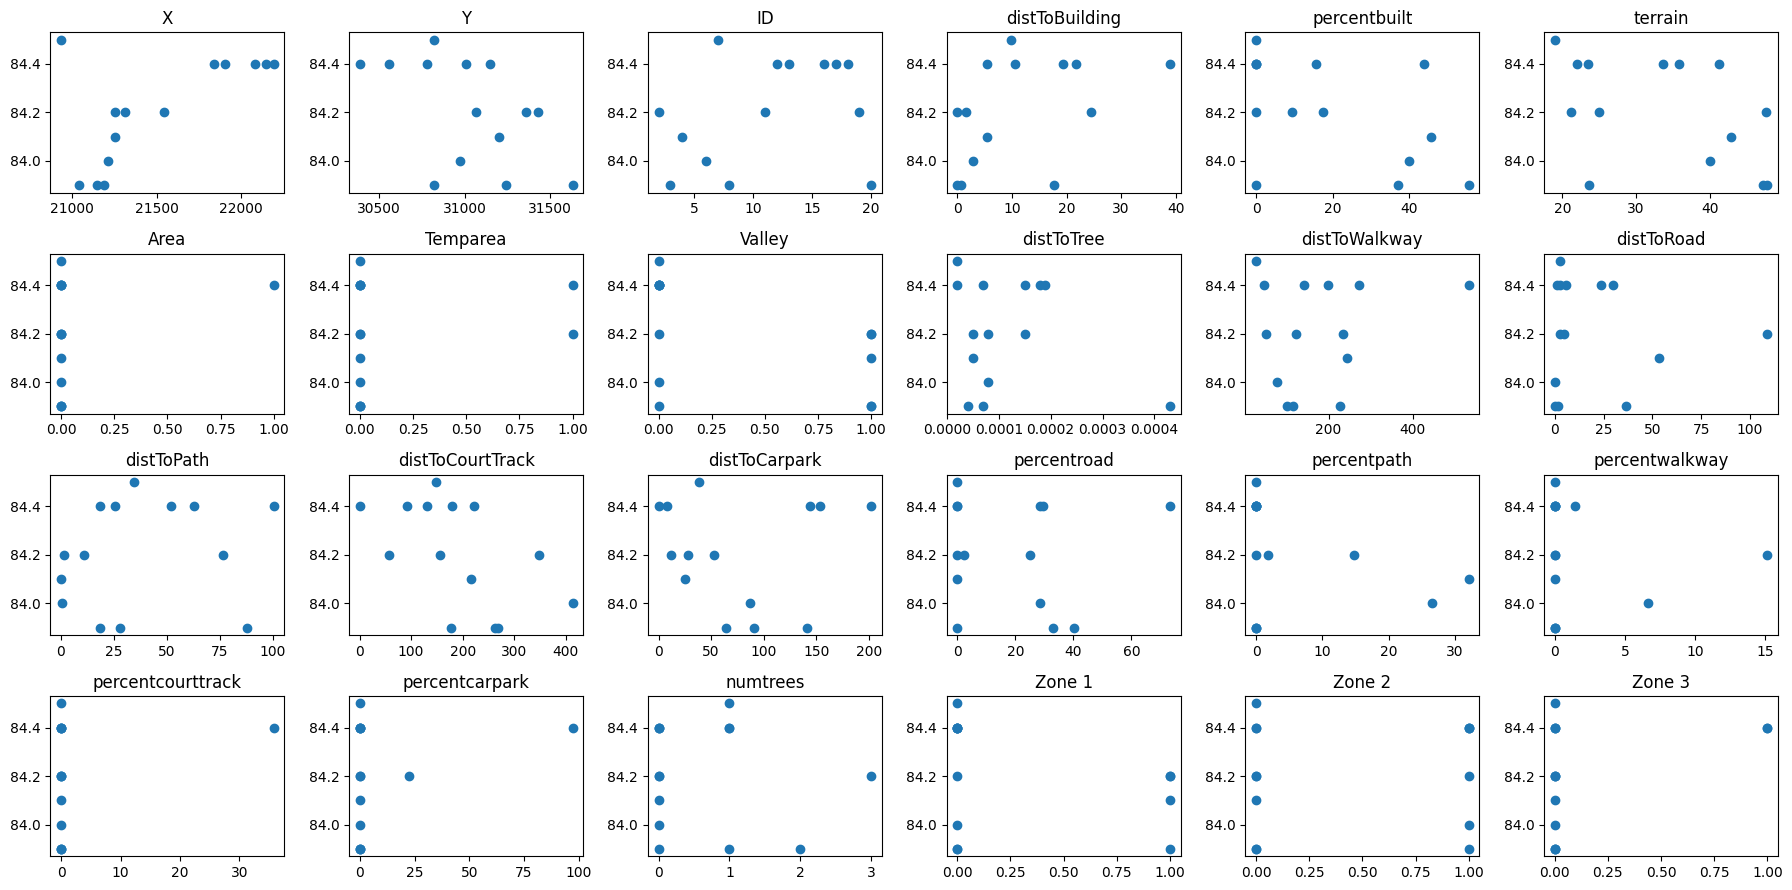

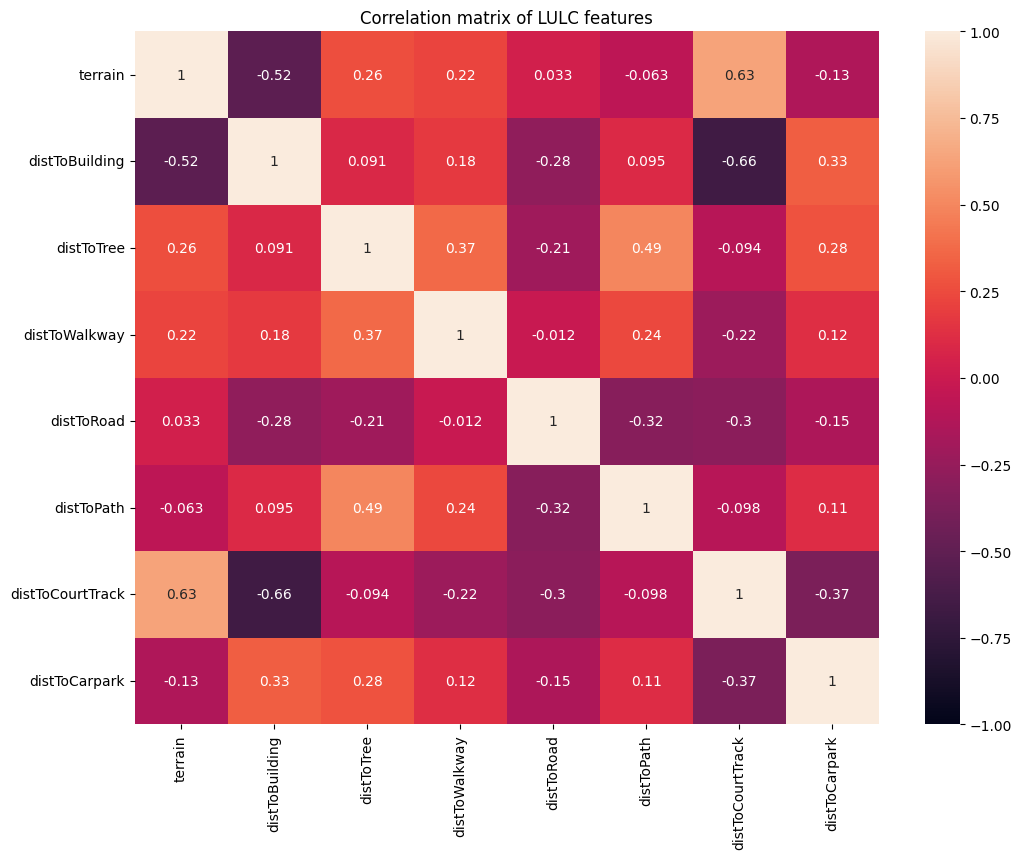

In [ ]:
#Plot scatterplot of each feature against average Tmax (Mar-19 weather station data)
fig, axs = plt.subplots(4, 6, figsize=(18, 9))

for i in range(4):
    for j in range(6):
        k = i * 6 + j
        if k >= len(wsdf.columns):
            break
        
        axs[i][j].scatter(wsdf[wsdf.columns[k]], df.iloc[2:16, 3])
        axs[i][j].set_title(wsdf.columns[k])

fig.tight_layout()
plt.show()

#Plot feature correlations using a heatmap
percentfeatures = ['percentroad', 'percentpath', 'percentwalkway', 'percentcourttrack', 'percentcarpark']
features = ['terrain', 'distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad', 'distToPath', 
            'distToCourtTrack', 'distToCarpark']

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(wsdf.corr().loc[features, features], vmin=-1, annot=True, ax=ax)
plt.title('Correlation matrix of LULC features')
plt.show()


Imports Libraries for LSTM Neural Network

In [30]:
import torch.nn as nn
from torch.autograd import Variable

#Defining features related to percentage of various land uses
percentfeatures = ['percentroad', 'percentpath', 'percentwalkway', 'percentcourttrack', 'percentcarpark']


Defining Classes for Neural Network Layers - Geolayer and Custom Model

In [2]:
import torch.nn as nn
from torch.autograd import Variable
import torch

# Function to return an LSTM model with specified parameters
def get_lstm_model(embedding_length, hidden_size, output_size):
    class LSTMModel(nn.Module):
        def __init__(self):
            super(LSTMModel, self).__init__()
            # Define LSTM layer and output layer
            self.hidden_size = hidden_size
            self.lstm = nn.LSTM(embedding_length, hidden_size, batch_first=True)
            self.label = nn.Linear(hidden_size, output_size)
        
        def forward(self, input):
            # Dynamically initialize hidden and cell states based on the input batch size
            batch_size = input.size(0)
            h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size))
            c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size))
            
            # Forward pass through LSTM
            output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
            
            # Output from the final hidden state
            return self.label(final_hidden_state[-1])
    
    return LSTMModel()

# Function to return a GRU model with specified parameters
def get_gru_model(embedding_length, hidden_size, output_size):
    class GRUModel(nn.Module):
        def __init__(self):
            super(GRUModel, self).__init__()
            # Define GRU layer and output layer
            self.hidden_size = hidden_size
            self.lstm = nn.GRU(embedding_length, hidden_size, batch_first=True)
            self.label = nn.Linear(hidden_size, output_size)
        
        def forward(self, input):
            # Dynamically initialize hidden state based on the input batch size
            batch_size = input.size(0)
            h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size))
            
            # Forward pass through GRU
            output, final_hidden_state = self.lstm(input, h_0)
            
            # Output from the final hidden state
            return self.label(final_hidden_state[-1])
    
    return GRUModel()


Training the Model

In [3]:
#Function to train a model with specified training data and optimizer
def train_model(model, train_iter, epoch, optimizer):
    model.train()  #Set model to training mode
    for e in range(epoch):  #Loop over each epoch
        loss = 0
        optimizer.zero_grad()  #Reset gradients
        
        #Loop through training batches
        for idx, batch in enumerate(train_iter):
            prediction = model(batch.x)  #Get model predictions
            loss += torch.norm(prediction - batch.y, "fro")  #Compute Frobenius norm of prediction error
        
        loss /= (idx + 1)  #Normalize the loss by the number of batches
        print(f"epoch {e}: Training Loss normalized Root MSE : {np.sqrt(loss.detach().numpy())} %")
        
        #Perform backpropagation and optimizer step
        loss.backward()
        optimizer.step()
        
        if loss < 0.1:  #Early stopping if loss is very small
            break
    return loss  #Return the final loss value


Data Preparation Function

In [4]:
class Mydata:
    def __init__(self, input_tensor, target_tensor):
        #Constructor method: Initializes the Mydata object with input data (features) and target data (labels)
        #Parameters:
        #input_tensor: A tensor containing the features (input data) for the model
        #target_tensor: A tensor containing the target (labels) for the corresponding input data
        self.x = input_tensor  #Store input data (features) in the object
        self.y = target_tensor  #Store target data (labels) in the object    
    def __getitem__(self, index):
        #Method to retrieve a specific data point from the dataset
        #Parameters:
        #index: Index of the data point to retrieve
        #Returns:
        #A tuple containing the input features and the corresponding target value for the given index
        return self.x[index], self.y[index]
    def __len__(self):
        #Method to get the total number of data points in the dataset
        #Returns:
        #The length of the input data (i.e., the number of samples in the dataset)
        return len(self.x)

#Function to prepare training and test data for model training
def prepare_data(batchsize, embedding_length, targetstationid, mean, std, hourdata, testhourdata):
    data = []  #List to store training data
    testdata = []  #List to store test data

    #Handle case where batch size is 1
    if batchsize == 1:
        #Loop over the hourdata to create training batches
        for i in range(0, hourdata.shape[0] - embedding_length - batchsize, batchsize):
            data.append(Mydata(
                torch.tensor((np.delete(hourdata[i:i+embedding_length, :], targetstationid, axis=1) - mean) / std, dtype=torch.float32).transpose(0, 1),
                torch.tensor((np.delete(hourdata[i+embedding_length:i+1+embedding_length, :], targetstationid, axis=1) - mean) / std, dtype=torch.float32)
            ))
        #Loop over the testhourdata to create test batches
        for i in range(0, testhourdata.shape[0] - embedding_length - batchsize, batchsize):
            testdata.append(Mydata(
                torch.tensor((np.delete(testhourdata[i:i+embedding_length, :], targetstationid, axis=1) - mean) / std, dtype=torch.float32).transpose(0, 1),
                torch.tensor((np.delete(testhourdata[i+embedding_length:i+1+embedding_length, :], targetstationid, axis=1) - mean) / std, dtype=torch.float32)
            ))
    else:
        #Loop over the data in larger batches
        for i in range(0, hourdata.shape[0] - embedding_length - batchsize, batchsize):
            data.append(Mydata(
                torch.tensor(np.array([(np.delete(hourdata[i+k:i+k+embedding_length, :], targetstationid, axis=1) - mean) / std for k in range(batchsize)]), dtype=torch.float32).transpose(1, 2),
                torch.tensor((np.delete(hourdata[i+embedding_length:i+batchsize+embedding_length, :], targetstationid, axis=1) - mean) / std, dtype=torch.float32)
            ))
        for i in range(0, testhourdata.shape[0] - embedding_length - batchsize, batchsize):
            testdata.append(Mydata(
                torch.tensor(np.array([(np.delete(testhourdata[i+k:i+k+embedding_length, :], targetstationid, axis=1) - mean) / std for k in range(batchsize)]), dtype=torch.float32).transpose(1, 2),
                torch.tensor((np.delete(testhourdata[i+embedding_length:i+batchsize+embedding_length, :], targetstationid, axis=1) - mean) / std, dtype=torch.float32)
            ))
    
    return data, testdata  #Return the prepared training and test data


Storing the Results

In [35]:
def store_predictions(puredata, methods, plotdf, base_measure, embedding_length, data_length, batchsize):
    """
    Store the model's predictions in the puredata dictionary with the correct key.

    :param puredata: Dictionary to store the predictions
    :param methods: List of method suffixes (e.g., '_lstmrk_', '_lstmok_')
    :param plotdf: DataFrame of model predictions
    :param base_measure: Base measure name (e.g., 'RH0719')
    :param embedding_length: Embedding length used for the model
    :param data_length: Length of the data
    :param batchsize: Size of each batch of data
    :return: Updated puredata dictionary
    """
    for method in methods:
        # Construct the key as base_measure + method (e.g., 'RH0719_lstmrk_')
        full_key = base_measure + method
        try:
            puredata[full_key] = plotdf.iloc[:, embedding_length:embedding_length + data_length * batchsize].to_numpy()
        except Exception as e:
            print(f"Error storing predictions for {full_key}: {e}")
    return puredata

Data Preparation for the Model

In [36]:
def prepare_input_data(datadir, file_name, testdf, wsdf):
    """
    Prepares input data by reading a CSV file, reshaping it, and calculating mean and std.
    :param datadir: The directory where the CSV files are located
    :param file_name: The name of the CSV file (e.g., 'RH0719') without any method suffix
    :param testdf: Test DataFrame
    :param wsdf: Weather station DataFrame
    :return: hourdata, testhourdata, mean, std, pdhourdata
    """
    # Load the data from the CSV file
    npdata = np.array(pd.read_csv(datadir + file_name + '.csv').iloc[:, 2:16])
    hourdata = np.sum(npdata.reshape([-1, 60, 14]), axis=1) / 60
    testhourdata = np.sum(np.array(testdf.iloc[:, 2:16]).reshape([-1, 60, 14]), axis=1) / 60

    # Calculate mean and standard deviation for normalization
    mean = hourdata.mean()
    std = hourdata.std()

    # Create DataFrame for the reshaped hourly data
    pdhourdata = pd.DataFrame(hourdata).transpose()
    pdhourdata['X'] = list(wsdf['X'])  # Add X coordinates to DataFrame
    pdhourdata['Y'] = list(wsdf['Y'])  # Add Y coordinates to DataFrame

    return hourdata, testhourdata, mean, std, pdhourdata


Error Matrix and Clustering

In [ ]:
from sklearn.cluster import KMeans

def calculate_clustering(puredata, measure, nclu=4):
    """
    Calculates the clustering for a given measure using KMeans.
    :param puredata: Dictionary containing prediction data
    :param measure: The key to use for extracting the measure from puredata
    :param nclu: Number of clusters (default is 4)
    :return: clusterresult and kmeans
    """
    #Extract error matrix based on the measure and reshape it
    errormatrix = np.array(puredata[measure])
    errormatrix = errormatrix[:, 8:-16]  # Trim the matrix
    tmperror = errormatrix.reshape(-1, 24)  # Reshape to 24-hour segments

    #Perform KMeans clustering on the reshaped data
    kmeans = KMeans(n_clusters=nclu, random_state=0, n_init="auto").fit(tmperror)
    
    #Reshape the clustering results and initialize the cluster result matrix
    tmpclusterresult = kmeans.labels_.reshape(14, -1)
    clusterresult = np.zeros((14, nclu))

    #Calculate the cluster membership for each cluster
    for i in range(14):
        for j in range(nclu):   
            clusterresult[i, j] = np.sum(tmpclusterresult[i, :] == j)

    #Normalize the cluster result
    clusterresult = clusterresult / tmpclusterresult.shape[1]

    return clusterresult, kmeans

Plotting Time Series Cluster

In [ ]:
def plot_time_series_clustering(puredata, measure, kmeans, nclu=4, ylabel='(Unit: %)'):
    """
    Plots the time series clustering for the given measure.

    :param puredata: Dictionary containing prediction data
    :param measure: The key (e.g., 'Tem0719_lstmrk_') to use for extracting the measure from puredata
    :param kmeans: KMeans object containing cluster information
    :param nclu: Number of clusters (default is 4)
    :param ylabel: Label for the y-axis (default is '(Unit: %)')
    """
    #Extract and reshape the time series data for the specified measure
    tmparray = np.array(puredata[measure])[:, 8:-16].reshape(-1, 24)

    #Set up the color palette for the clusters
    colors = sns.color_palette()

    #Create the plot
    fig, ax = plt.subplots()

    #Plot each individual time series with transparency
    for i in range(tmparray.shape[0]):
        sns.lineplot(tmparray[i, :], color=colors[kmeans.labels_[i]], alpha=0.08, ax=ax)

    #Plot the mean time series for each cluster
    for j in range(nclu):
        sns.lineplot(tmparray[kmeans.labels_ == j, :].mean(axis=0), color=colors[j], linewidth=2, ax=ax)

    #Configure the axis labels and title
    ax.set_xticks([0, 6, 12, 18, 24])
    ax.set_xlabel('Time of Day')
    ax.set_ylabel(ylabel)
    ax.set_title(f'Time Series Clustering of {measure} Prediction Errors')

    #Add the custom legend for clusters
    custom_lines = [plt.Line2D([0], [0], color=colors[j], lw=2) for j in range(nclu)]
    ax.legend(custom_lines, [f'Cluster {j}' for j in range(nclu)])

    plt.show()

Available keys in puredata: dict_keys(['RH0719_lstmrk_', 'RH0719_lstmok_', 'RH0719_grurk_', 'RH0719_gruok_'])


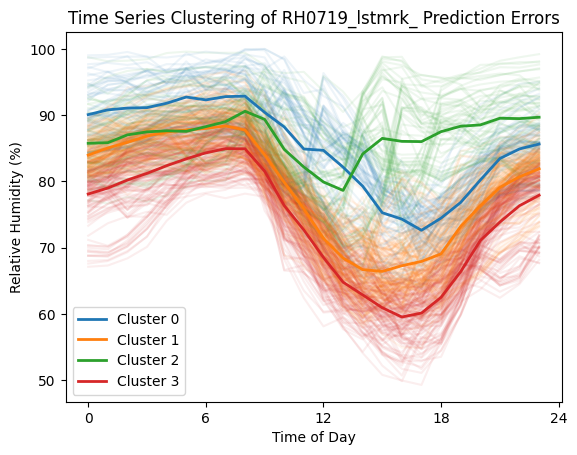

In [ ]:
# Define embedding length, batch size, and other necessary parameters
embedding_length = 15  # Example value for embedding length
batchsize = 16  # Example batch size
base_measure = 'RH0719'  # Base measure name (e.g., 'RH0719') without any method suffix

datadir = 'C:\\Users\\zeyuj\\OneDrive\\Desktop\\GNI Repo\\24Fa-Microclimate-UWG\\data\\'

nclu = 4  # Number of clusters
methods = ['_lstmrk_', '_lstmok_', '_grurk_', '_gruok_']  # Example methods

# Step 1: Prepare the input data
# Pass the base file name ('RH0719') without the method suffix
hourdata, testhourdata, mean, std, pdhourdata = prepare_input_data(datadir, base_measure, testdf, wsdf)

# Step 2: Prepare training and test data for model input
targetstationid = 0  # Example target station ID, update this based on your data
training_data, testing_data = prepare_data(batchsize, embedding_length, targetstationid, mean, std, hourdata, testhourdata)

# Step 3: Initialize an empty dictionary for puredata to store predictions
puredata = {}

# Step 4: Store predictions in puredata using base_measure + method
puredata = store_predictions(puredata, methods, pdhourdata, base_measure, embedding_length, len(training_data), batchsize)

print("Available keys in puredata:", puredata.keys())

# Step 5: Perform clustering on the stored prediction error matrix
# Choose the full key for the measure and method combination
measure_key = base_measure + '_lstmrk_'  # Example measure key (adjust this based on the method you want to analyze)
clusterresult, kmeans = calculate_clustering(puredata, measure_key, nclu=nclu)

# Step 6: Add the clustering result back to the wsdf DataFrame
wsdf['cluster'] = list(clusterresult)

# Step 7: Plot the time series clustering results for the selected measure
plot_time_series_clustering(puredata, measure_key, kmeans, nclu=nclu, ylabel='Relative Humidity (%)')


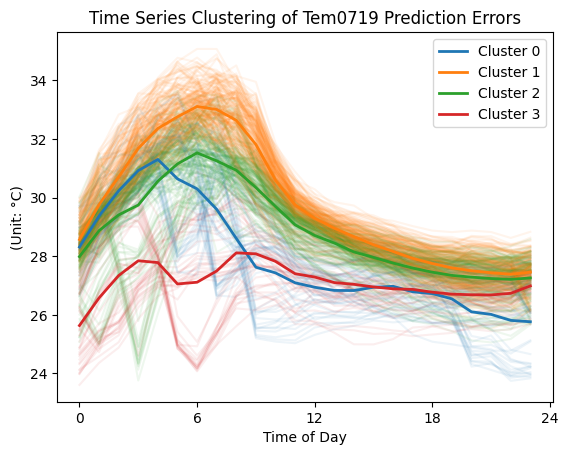

In [ ]:
# Set the measurement type and base file name
measure = 'Tem0719'
base_measure = measure

# Step 1: Prepare the input data using the existing function
hourdata, testhourdata, mean, std, pdhourdata = prepare_input_data(datadir, base_measure, testdf, wsdf)

# Step 2: Store the reshaped temperature data in the puredata dictionary for clustering and plotting
puredata[measure] = pdhourdata.iloc[:, :-2].to_numpy()  # Store only the time series data, excluding 'X' and 'Y' columns

# Step 3: Perform KMeans clustering on the stored prediction data
clusterresult, kmeans = calculate_clustering(puredata, measure, nclu=nclu)

# Step 4: Plot the time series clustering using the existing function
plot_time_series_clustering(puredata, measure, kmeans, nclu=nclu, ylabel=f'(Unit: {measureunit[measure]})')


In [5]:
from epw import epw
CRC = epw()
CRC.read(r"C:\Users\zeyuj\OneDrive\Desktop\GNI Repo\24Fa-Microclimate-UWG\data\CRC.epw")


In [6]:
CRC_df = CRC.dataframe
CRC_df

,Year,Month,Day,Hour,Minute,Data Source and Uncertainty Flags,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
0,2023,1,1,1,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.7,12.8,93.2,101253.061,...,4500,9,999999999,300,0.062,0,88,0.17,0.0,6.0
1,2023,1,1,2,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.5,12.8,94.0,101253.061,...,750,9,999999999,300,0.062,0,88,0.17,999.0,99.0
2,2023,1,1,3,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.5,12.8,94.0,101253.061,...,15,9,999999999,300,0.062,0,88,0.17,999.0,99.0
3,2023,1,1,4,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.1,12.1,94.0,101253.061,...,1230,9,999999999,300,0.062,0,88,0.17,999.0,99.0
4,2023,1,1,5,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,12.4,11.7,94.0,101253.061,...,15,9,999999999,300,0.062,0,88,0.17,999.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023,12,31,20,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,10.4,1.2,53.9,101591.700,...,77777,9,999999999,110,0.062,0,88,0.16,999.0,99.0
8756,2023,12,31,21,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,9.9,1.1,55.1,101591.700,...,77777,9,999999999,110,0.062,0,88,0.16,999.0,99.0
8757,2023,12,31,22,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,9.4,1.1,56.1,101591.700,...,77777,9,999999999,110,0.062,0,88,0.16,999.0,99.0
8758,2023,12,31,23,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,8.9,0.9,57.9,101591.700,...,77777,9,999999999,110,0.062,0,88,0.16,999.0,99.0


In [7]:
CRC_df.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute',
       'Data Source and Uncertainty Flags', 'Dry Bulb Temperature',
       'Dew Point Temperature', 'Relative Humidity',
       'Atmospheric Station Pressure', 'Extraterrestrial Horizontal Radiation',
       'Extraterrestrial Direct Normal Radiation',
       'Horizontal Infrared Radiation Intensity',
       'Global Horizontal Radiation', 'Direct Normal Radiation',
       'Diffuse Horizontal Radiation', 'Global Horizontal Illuminance',
       'Direct Normal Illuminance', 'Diffuse Horizontal Illuminance',
       'Zenith Luminance', 'Wind Direction', 'Wind Speed', 'Total Sky Cover',
       'Opaque Sky Cover (used if Horizontal IR Intensity missing)',
       'Visibility', 'Ceiling Height', 'Present Weather Observation',
       'Present Weather Codes', 'Precipitable Water', 'Aerosol Optical Depth',
       'Snow Depth', 'Days Since Last Snowfall', 'Albedo',
       'Liquid Precipitation Depth', 'Liquid Precipitation Quantity'],
      dtype='obj

In [8]:
# Select features and target column (example columns, replace with your actual ones)
target_col = 'Dry Bulb Temperature'
feature_cols = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Dry Bulb Temperature',
       'Dew Point Temperature', 'Relative Humidity',
       'Atmospheric Station Pressure', 'Extraterrestrial Horizontal Radiation',
       'Extraterrestrial Direct Normal Radiation',
       'Horizontal Infrared Radiation Intensity',
       'Global Horizontal Radiation', 'Direct Normal Radiation',
       'Diffuse Horizontal Radiation', 'Global Horizontal Illuminance',
       'Direct Normal Illuminance', 'Diffuse Horizontal Illuminance',
       'Zenith Luminance', 'Wind Direction', 'Wind Speed', 'Total Sky Cover',
       'Opaque Sky Cover (used if Horizontal IR Intensity missing)',
       'Visibility', 'Ceiling Height', 'Present Weather Observation',
       'Present Weather Codes', 'Precipitable Water', 'Aerosol Optical Depth',
       'Snow Depth', 'Days Since Last Snowfall', 'Albedo',
       'Liquid Precipitation Depth', 'Liquid Precipitation Quantity']

In [39]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Extract features and target
features = CRC_df[feature_cols].values
target = CRC_df[target_col].values.reshape(-1, 1)

# Normalize features and target
scaler_features = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_target.fit_transform(target)

# Define sequence length
sequence_length = 10

In [40]:
# Function to create sequences for LSTM
def create_sequences(input_data, target_data, seq_length):
    in_seq, out_seq = [], []
    for i in range(len(input_data) - seq_length):
        in_seq.append(input_data[i:i+seq_length])
        out_seq.append(target_data[i + seq_length])
    return np.array(in_seq), np.array(out_seq)

X, y = create_sequences(features_scaled, target_scaled, sequence_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)


In [41]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

In [ ]:
# Define model parameters
embedding_length = X_train_tensor.shape[2]  # Number of features
hidden_size = 50
output_size = 1

# Get the LSTM model
model = get_lstm_model(embedding_length=embedding_length, hidden_size=hidden_size, output_size=output_size)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, X_train, y_train, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(X_train)
        loss = criterion(output, y_train)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Train the model
train_model(model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs=100)


Epoch [10/100], Loss: 0.0551
Epoch [20/100], Loss: 0.0263
Epoch [30/100], Loss: 0.0180
Epoch [40/100], Loss: 0.0173
Epoch [50/100], Loss: 0.0165
Epoch [60/100], Loss: 0.0152
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0116
Epoch [90/100], Loss: 0.0075
Epoch [100/100], Loss: 0.0054


Test RMSE: 2.2990


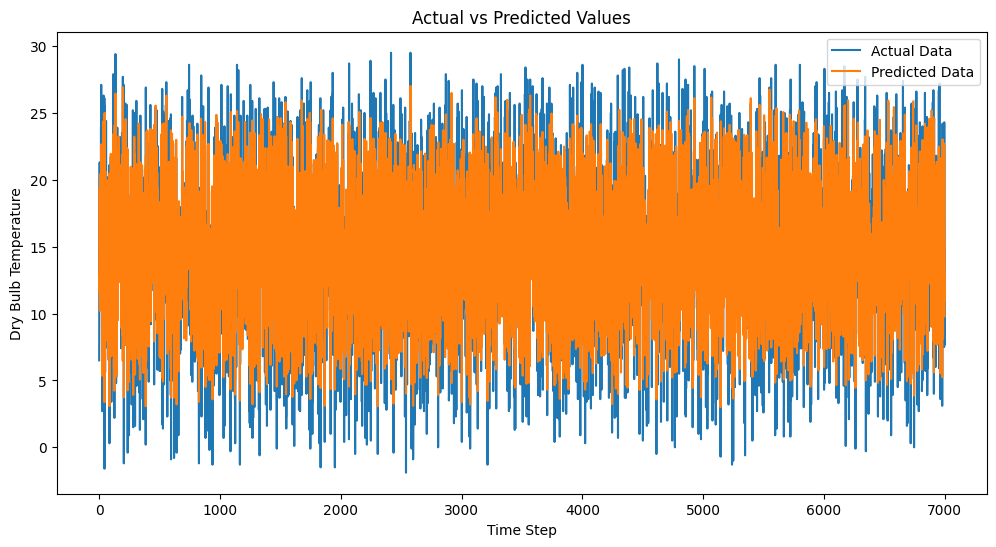

In [43]:
# Switch model to evaluation mode
model.eval()
with torch.no_grad():
    # Make predictions
    train_predict = model(X_test_tensor)
    predicted = train_predict.data.numpy()
    actual = y_test_tensor.numpy()

    # Inverse transform to get original scale
    predicted_actual = scaler_target.inverse_transform(predicted)
    actual_actual = scaler_target.inverse_transform(actual)

# Calculate RMSE
rmse = np.sqrt(np.mean((predicted_actual - actual_actual) ** 2))
print(f'Test RMSE: {rmse:.4f}')

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(actual_actual, label='Actual Data')
plt.plot(predicted_actual, label='Predicted Data')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel(target_col)
plt.title('Actual vs Predicted Values')
plt.show()


Test RMSE: 2.2990


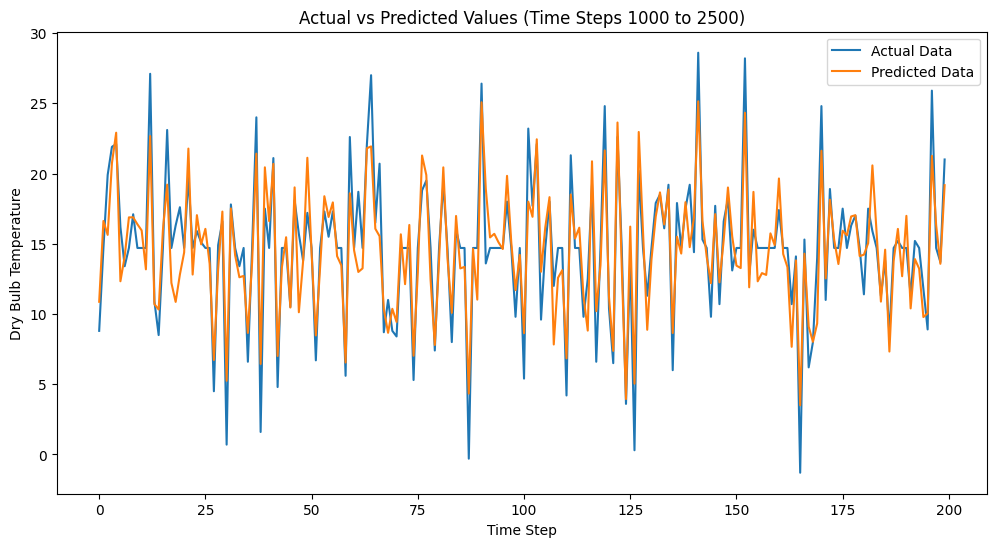

In [44]:
# Switch model to evaluation mode
model.eval()
with torch.no_grad():
    # Make predictions
    train_predict = model(X_test_tensor)
    predicted = train_predict.data.numpy()
    actual = y_test_tensor.numpy()

    # Inverse transform to get original scale
    predicted_actual = scaler_target.inverse_transform(predicted)
    actual_actual = scaler_target.inverse_transform(actual)

# Calculate RMSE
rmse = np.sqrt(np.mean((predicted_actual - actual_actual) ** 2))
print(f'Test RMSE: {rmse:.4f}')

# Plot actual vs. predicted for range 1000 to 2500
plt.figure(figsize=(12, 6))
plt.plot(actual_actual[1000:1200], label='Actual Data')
plt.plot(predicted_actual[1000:1200], label='Predicted Data')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel(target_col)
plt.title('Actual vs Predicted Values (Time Steps 1000 to 2500)')
plt.show()
